In [5]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

## Create Amazon Customer Reviews DataFrame from JSON objects

In [6]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Cell_Phones_and_Accessories_5.json.gz')

df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,1391817600,NaN,NaN
3,2.0,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,1391472000,NaN,NaN
4,4.0,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,1391385600,NaN,NaN


In [7]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

overall           0      
verified          0      
reviewTime        0      
reviewerID        0      
asin              0      
style             522684 
reviewerName      133    
reviewText        0      
summary           0      
unixReviewTime    0      
vote              1035232
image             1100212
dtype: int64

In [8]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

5.0    706102
4.0    184293
3.0    98189 
1.0    81469 
2.0    57153 
Name: overall, dtype: int64


5.0    62.641789
4.0    16.349540
3.0    8.710830 
1.0    7.227517 
2.0    5.070324 
Name: overall, dtype: float64

## Separate positive and negative reviews for analysis

In [9]:
df_negative_reviews = df[df['overall']<3].iloc[:100000]
df_positive_reviews = df[df['overall']>3].iloc[:200000]

In [10]:
df_new = df.iloc[:100]
df_new.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,1391817600,NaN,NaN
3,2.0,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,1391472000,NaN,NaN
4,4.0,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,1391385600,NaN,NaN


## Review Text PreProcssing Function Definitions

In [11]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [12]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)
    
    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
#     wrds = TOKENIZER.tokenize(sent_without_punct)
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)

## Create Negative Reviews WordCloud

In [13]:
tmp = list()
for i in range(100000):
    tmp.append(cleanme(df_negative_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_negative_reviews_new = df_negative_reviews.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_negative_reviews_new = pd.concat([df_negative_reviews_new,tmp], axis=1)
df_negative_reviews_new = df_negative_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_negative_reviews_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
1,2.0,The product looked exactly like the picture and it was very nice. However only days later it fell apart. I'm very disappointed with the quality of the product.,Not so happy,14,product looked exactly like picture nice however days later fell apart disappointed quality product,nice disappointed
2,1.0,DO NOT BUY! this item is seriously cheap as heck. not worth buying it at all. I didn't even get to use it and it was already losing all of its gems. I wish I got my money back on this item!!,WORST ITEM!,21,not buy item seriously cheap heck not worth buying not even get use already losing gems wish got money back item,cheap worth wish
3,1.0,Very cheap broke the first time we put it on :( It was pretty but very cheaply made!! Too bad as it is cute,cheap plastic,10,cheap broke first time put pretty cheaply made bad cute,cheap first bad cute
4,2.0,"I used this case for not even a week and the bow came off. I loved it so pretty, but wish it would of stayed together.",....,13,used case not even week bow came loved pretty wish would stayed together,wish


In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_negative_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]
bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(40)

[(('would', 'not', 'recommend'), 1893),
 (('not', 'waste', 'money'), 1154),
 (('not', 'fit', 'phone'), 1054),
 (('screen', 'protector', 'not'), 963),
 (('could', 'not', 'get'), 779),
 (('case', 'not', 'fit'), 735),
 (('would', 'not', 'buy'), 715),
 (('glass', 'screen', 'protector'), 691),
 (('not', 'last', 'long'), 603),
 (('not', 'work', 'well'), 585),
 (('not', 'recommend', 'product'), 579),
 (('not', 'work', 'not'), 494),
 (('not', 'worth', 'money'), 476),
 (('not', 'fit', 'well'), 470),
 (('not', 'charge', 'phone'), 450),
 (('not', 'hold', 'charge'), 442),
 (('waste', 'money', 'not'), 401),
 (('phone', 'would', 'not'), 401),
 (('would', 'not', 'charge'), 372),
 (('not', 'protect', 'phone'), 372),
 (('not', 'recommend', 'case'), 370),
 (('would', 'not', 'stay'), 367),
 (('not', 'fit', 'iphone'), 340),
 (('not', 'buy', 'not'), 330),
 (('would', 'not', 'work'), 321),
 (('not', 'waste', 'time'), 319),
 (('phone', 'not', 'work'), 308),
 (('phone', 'case', 'not'), 301),
 (('not', 'recomm

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashishkannur91\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

In [17]:
d

{'not_care_gave': 1,
 'care_gave_gift': 1,
 'gave_gift_okay': 1,
 'gift_okay_not': 1,
 'okay_not_expected': 2,
 'not_expected_product': 7,
 'expected_product_looked': 1,
 'product_looked_exactly': 2,
 'looked_exactly_like': 5,
 'exactly_like_picture': 14,
 'like_picture_nice': 1,
 'picture_nice_however': 1,
 'nice_however_day': 2,
 'however_day_later': 2,
 'day_later_fell': 2,
 'later_fell_apart': 2,
 'fell_apart_disappointed': 3,
 'apart_disappointed_quality': 1,
 'disappointed_quality_product': 17,
 'quality_product_not': 48,
 'product_not_buy': 63,
 'not_buy_item': 80,
 'buy_item_seriously': 1,
 'item_seriously_cheap': 1,
 'seriously_cheap_heck': 1,
 'cheap_heck_not': 1,
 'heck_not_worth': 1,
 'not_worth_buying': 70,
 'worth_buying_not': 9,
 'buying_not_even': 3,
 'not_even_get': 132,
 'even_get_use': 7,
 'get_use_already': 2,
 'use_already_losing': 1,
 'already_losing_gem': 1,
 'losing_gem_wish': 1,
 'gem_wish_got': 1,
 'wish_got_money': 1,
 'got_money_back': 44,
 'money_back_item'

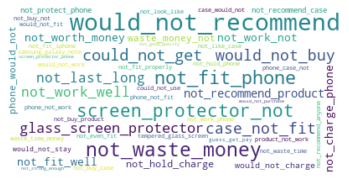

In [18]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Bigrams_frequent_words.png")

In [19]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


## Create Positive Reviews WordCloud

In [20]:
tmp = list()
for i in range(150000):
    tmp.append(cleanme(df_positive_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_positive_reviews_new = df_positive_reviews.reset_index()
df_positive_reviews_new = pd.concat([df_positive_reviews_new,tmp], axis=1)
df_positive_reviews_new = df_positive_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_positive_reviews_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23.0,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11.0,not want spend whole lot cash want great deal shop buy,whole great
2,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13.0,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs
3,5.0,"It is a very cute case. None of the jewels have fallen off and the bow is glued on very well. Came in the time frame that was given and I'm happy with this purchase. The only thing you might want to know is, I carry my phone in my jeans and it does fit very tightly because it is a big bow. You have to be careful but worth it.",Cute case,27.0,cute case none jewels fallen bow glued well came time frame given happy purchase thing might want know carry phone jeans fit tightly big bow careful worth,cute happy only fit big careful worth
4,4.0,"I really love this case... you have to keep your phone face down all the time, but it's pretty good quality. Some stones come off from normal use, unless you keep it in your purse all day.",Pretty Cute!,18.0,really love case keep phone face time pretty good quality stones come normal use unless keep purse day,good normal


In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_positive_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]

bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(30)

[(('would', 'highly', 'recommend'), 679),
 (('fit', 'phone', 'perfectly'), 668),
 (('would', 'recommend', 'anyone'), 656),
 (('would', 'definitely', 'recommend'), 634),
 (('screen', 'protector', 'not'), 591),
 (('not', 'go', 'wrong'), 560),
 (('typehidden', 'name', 'valuehttpsimagesna'), 536),
 (('name', 'valuehttpsimagesna', 'sslimagesamazon'), 536),
 (('fit', 'like', 'glove'), 534),
 (('not', 'big', 'deal'), 464),
 (('not', 'beat', 'price'), 454),
 (('not', 'add', 'much'), 442),
 (('last', 'long', 'time'), 429),
 (('would', 'recommend', 'product'), 421),
 (('case', 'fit', 'perfectly'), 420),
 (('really', 'like', 'case'), 411),
 (('highly', 'recommend', 'product'), 406),
 (('protects', 'phone', 'well'), 403),
 (('case', 'fit', 'phone'), 397),
 (('samsung', 'galaxy', 'note'), 395),
 (('great', 'product', 'great'), 377),
 (('thing', 'not', 'like'), 368),
 (('highly', 'recommend', 'case'), 348),
 (('fit', 'phone', 'well'), 332),
 (('love', 'love', 'love'), 315),
 (('get', 'job', 'done'),

In [22]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

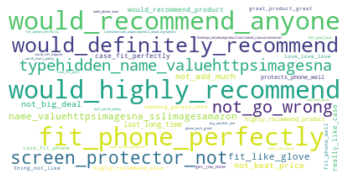

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Positive_Reviews.png")

## PreProcess 200K reviews to be used to build classification models

In [24]:
df_new = df.iloc[:200000]

tmp = list()
for i in range(200000):
    tmp.append(cleanme(df_new.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_new = df_new.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_new = pd.concat([df_new,tmp], axis=1)
df_new = df_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs


In [25]:
df_new.columns = ['overall_rating','reviewText','summary','cleanReviewLength', 'cleanReview', 'adjectives']
df_new.head()

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs


## Calculate Polarity of Reviews

In [26]:
from textblob import TextBlob, Word
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df_new['polarity'] = df_new.reviewText.apply(detect_polarity)
df_new[1:10]

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives,polarity
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great,0.600000
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable,-0.004167
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,,0.200000
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs,0.511111
5,2.0,The product looked exactly like the picture and it was very nice. However only days later it fell apart. I'm very disappointed with the quality of the product.,Not so happy,14,product looked exactly like picture nice however days later fell apart disappointed quality product,nice disappointed,0.011000
6,3.0,I FINALLY got my case today. It took forever to get here! It's cute and looks just like the pic. Like right after I wrote this review some of the rhinestones started falling off. The package does come with glue to glue them back on but in my opinion this case is only good for a couple of days (if that.) I wouldn't purchase another. Thanks you,It's cute!,33,finally got case today took forever get cute looks like pic like right wrote review rhinestones started falling package come glue glue back opinion case good couple days would not purchase another thanks,cute good,0.240816
7,5.0,"It is a very cute case. None of the jewels have fallen off and the bow is glued on very well. Came in the time frame that was given and I'm happy with this purchase. The only thing you might want to know is, I carry my phone in my jeans and it does fit very tightly because it is a big bow. You have to be careful but worth it.",Cute case,27,cute case none jewels fallen bow glued well came time frame given happy purchase thing might want know carry phone jeans fit tightly big bow careful worth,cute happy only fit big careful worth,0.224206
8,1.0,DO NOT BUY! this item is seriously cheap as heck. not worth buying it at all. I didn't even get to use it and it was already losing all of its gems. I wish I got my money back on this item!!,WORST ITEM!,21,not buy item seriously cheap heck not worth buying not even get use already losing gems wish got money back item,cheap worth wish,0.083333
9,4.0,"I really love this case... you have to keep your phone face down all the time, but it's pretty good quality. Some stones come off from normal use, unless you keep it in your purse all day.",Pretty Cute!,18,really love case keep phone face time pretty good quality stones come normal use unless keep purse day,good normal,0.288889


## Naive Bayes Multi-Class Classifier

In [27]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import sparse

tfidf = TfidfVectorizer(sublinear_tf=False, max_features = 10000, min_df=5,max_df=0.60,ngram_range= (1,2))

((33114, 6), (8279, 6))

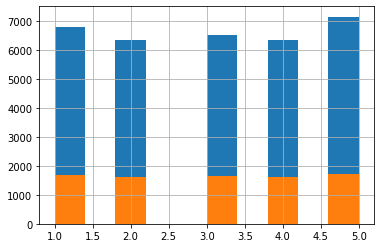

In [28]:

review_df = pd.concat([df_new[df_new['overall_rating']==1.0].sample(n=10000),df_new[df_new['overall_rating']==2.0].sample(n=10000),
                    df_new[df_new['overall_rating']==3.0].sample(n=10000),df_new[df_new['overall_rating']==4.0].sample(n=10000),
                    df_new[df_new['overall_rating']==5.0].sample(n=10000)])
review_df = review_df[review_df['cleanReviewLength']<50]
review_df = review_df[['cleanReview','overall_rating']]
train, test = train_test_split(review_df, test_size=0.2)

train['overall_rating'].hist();
test['overall_rating'].hist();

train = pd.get_dummies(train, columns = ['overall_rating'])
train.head()

test = pd.get_dummies(test, columns = ['overall_rating'])
test.head()

train.shape, test.shape


In [29]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [30]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [32]:
class_names = ['overall_rating_1.0', 'overall_rating_2.0','overall_rating_3.0','overall_rating_4.0','overall_rating_5.0']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train['cleanReview'].values, y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['cleanReview'].values, train_target)
    preds[:,i] = p.predict_proba(test['cleanReview'].values)[:,1]

ValueError: provided out is the wrong size for the reduction

In [ ]:
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

## Some Analysis

5.0    115702
4.0    36215 
3.0    20788 
1.0    15830 
2.0    11465 
Name: overall_rating, dtype: int64


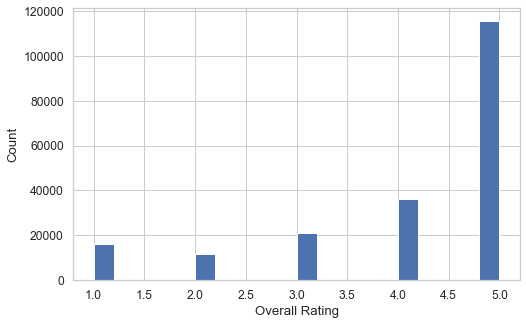

In [33]:
# df_new=df_new.rename(columns = {'overall':'overall_rating'})
import seaborn as sns
print(df_new['overall_rating'].value_counts())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_new['overall_rating']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Overall Rating', ylabel='Count');

   overall_rating  cleanReviewLength
0  1.0             30.522091        
1  2.0             37.586418        
2  3.0             34.564620        
3  4.0             38.774612        
4  5.0             25.417610        
   overall_rating  polarity
0  1.0             0.009891
1  2.0             0.097770
2  3.0             0.188911
3  4.0             0.272849
4  5.0             0.388435


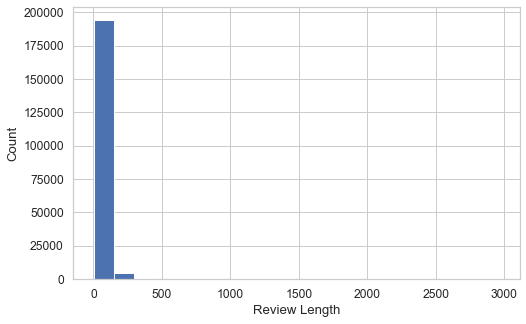

In [34]:
df_res = df_new[df_new['cleanReviewLength']>0]
print(df_res.groupby('overall_rating', as_index=False)['cleanReviewLength'].mean())
print(df_res.groupby('overall_rating', as_index=False)['polarity'].mean())

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_res['cleanReviewLength']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Review Length', ylabel='Count');

In [35]:
df_new.corr()

,overall_rating,cleanReviewLength,polarity
overall_rating,1.000000,-0.061283,0.411635
cleanReviewLength,-0.061283,1.000000,-0.186769
polarity,0.411635,-0.186769,1.000000


## Some Other Multi-Class Classifier Models which also takes into account Review Length and Polarity

In [36]:
df_res = pd.concat([df_new[df_new['overall_rating']==1.0].sample(n=10000),df_new[df_new['overall_rating']==2.0].sample(n=10000),
                    df_new[df_new['overall_rating']==3.0].sample(n=10000),df_new[df_new['overall_rating']==4.0].sample(n=10000),
                    df_new[df_new['overall_rating']==5.0].sample(n=10000)])
df_res = df_res[df_res['cleanReviewLength']<50]
df_res['overall_rating'].value_counts()

5.0    8851
1.0    8472
3.0    8174
2.0    7931
4.0    7884
Name: overall_rating, dtype: int64

In [37]:
df_100 = df_res.copy()

v = TfidfVectorizer(max_features = 10000, min_df=5,max_df=0.60)
x = v.fit_transform(df_100['cleanReview'])


df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
df_100 = df_100.drop('cleanReview', axis=1)

df_100.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)
# print(df_100)
res = pd.concat([df_100, df1], axis=1)


In [38]:
res1 = res[res.columns.difference(['reviewText','summary', 'adjectives', 'overall_rating'])]
normalized_res1 = res1
normalized_res1['cleanReviewLength']= (normalized_res1['cleanReviewLength']-normalized_res1['cleanReviewLength'].min())/(normalized_res1['cleanReviewLength'].max()-normalized_res1['cleanReviewLength'].min())
normalized_res1['polarity']= (normalized_res1['polarity']-normalized_res1['polarity'].min())/(normalized_res1['polarity'].max()-normalized_res1['polarity'].min())
# normalized_res1=(res1-res1.min())/(res1.max()-res1.min())
# print(normalized_res1.head(100))
y = res['overall_rating'].values.reshape(-1,1)

res1.shape, y.shape

# y = res['rating']
# len(y)

((41312, 5654), (41312, 1))

## Logistic Regression Classifier and ROC Curve

Multinomial Logistic regression Train Accuracy ::  0.6125752670277467
Multinomial Logistic regression Test Accuracy ::  0.48299649037879705
Area under ROC curve::  0.6752722144399764


Text(0.5, 257.44, 'Predicted label')

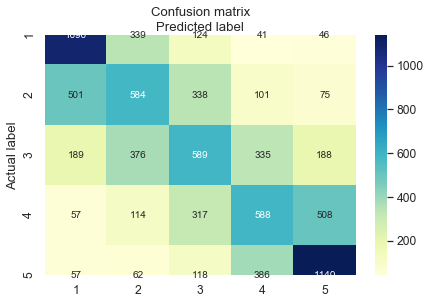

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state= 51)
lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)

print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
print ("Area under ROC curve:: ",multiclass_roc_auc_score(y_test,lr.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, lr.predict(X_test))


class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

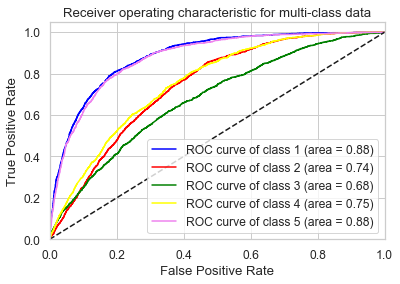

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =train_test_split(normalized_res1, y, test_size=0.2, random_state=51)

# classifier
clf = OneVsRestClassifier(linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg'))
y_score = clf.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [42]:
y_score

array([[-1.06560377, -0.36069673, -0.49854181, -1.01835211, -1.19628007],
       [-1.56399183, -0.95405445, -1.48002339, -0.59220435, -0.33302129],
       [-2.56578082, -2.37845297, -1.83754926, -1.00955875,  0.90139073],
       ...,
       [-1.1376952 , -0.69675692, -1.21957722, -0.06796293, -0.93991819],
       [-0.93462861, -0.4672917 , -0.71194208, -0.48770318, -1.72500312],
       [-3.30314544, -1.93632758, -0.74345636, -0.40992113, -0.5132746 ]])

## KNN Classifier

In [43]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2,random_state=51)
knn = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)

accuracy = knn.score(X_test, y_test) 
print (accuracy)
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cnf_matrix = metrics.confusion_matrix(y_test, knn_predictions) 

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

0.033764976400822946


ValueError: multilabel-indicator is not supported

## SVM Linear Classifier and ROC Curve

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state=51)
svm = LinearSVC()
svm.fit(X_train,y_train)

print ("Multinomial SVM Train Accuracy :: ", metrics.accuracy_score(y_train, svm.predict(X_train)))
print ("Multinomial SVM Test Accuracy :: ", metrics.accuracy_score(y_test, svm.predict(X_test)))
print ("Area under ROC curve:: ",multiclass_roc_auc_score(y_test,svm.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, svm.predict(X_test))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
# from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =train_test_split(normalized_res1, y, test_size=0.2, random_state=51)

# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)


#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Multinomial Naive Bayes Multi-Class Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_res['cleanReview'], df_res['overall_rating'], random_state = 51)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print ("Multinomial Naive Bayes Train Accuracy :: ", metrics.accuracy_score(y_train, clf.predict(X_train_tfidf)))
print ("Multinomial Naive Bayes Accuracy :: ", metrics.accuracy_score(y_test, clf.predict(count_vect.transform(X_test))))
print ("Area under ROC curve:: ",multiclass_roc_auc_score(y_test,clf.predict(count_vect.transform(X_test))))

cnf_matrix = metrics.confusion_matrix(y_test, clf.predict(count_vect.transform(X_test)))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
# from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_res['cleanReview'], y, random_state = 51)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# classifier
clf = OneVsRestClassifier(MultinomialNB())
y_score = clf.fit(X_train_tfidf, y_train).predict_proba(count_vect.transform(X_test))


#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()